In [1]:
import os
import sys
sys.dont_write_bytecode = True
sys.path.append("../scripts")
import scraper
import pickle
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.stats import linregress

In [2]:
# Make a list of all GHGRP IDs
years = [y for y in range(2010,2023)]
ghgrp_ids = set()
for year in years:
    summary_sheet = pd.read_excel("../resources/flight.xls", header=6,
                                  sheet_name=str(year))
    ghgrp_ids.update(set(summary_sheet["GHGRP ID"]))
ghgrp_ids = list(ghgrp_ids)

if os.path.exists("../resources/landfills_by_id.pkl"):

    # Load the saved file
    with open("../resources/landfills_by_id.pkl", "rb") as handle:
        landfills_by_id = pickle.load(handle)

else:

    # Use multiprocessing to collect all data
    inputs = [(id, "../resources/flight.xls") for id in ghgrp_ids]
    with multiprocessing.Pool() as pool:
        results = pool.starmap(scraper.scrape_flight_ghgrp, inputs)
        pool.close()
        pool.join()
    landfills_by_id = {}
    for ghgrp_id,result in zip(ghgrp_ids, results):
        landfills_by_id[ghgrp_id] = result

    # Save the file
    with open("../resources/landfills_by_id.pkl", "wb") as handle:
        pickle.dump(landfills_by_id, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Aggregate the data by year
landfills_by_year = {}
for year in years:
    series = []
    for id in ghgrp_ids:
        subset = landfills_by_id[id].loc[landfills_by_id[id]["year"] == year]
        if len(subset) > 0:
            series.append(subset)
    landfills_by_year[year] = pd.concat(series, ignore_index=True)

In [3]:
# Variables that are summed by year
totals = {k: np.zeros(len(years)) for k in 
          ["Emis_Reported", "If_All_Generation_First", "If_All_Recovery_First",
           "Recovered", "Waste_In_Place_Total", "Waste_Added_This_Yr"]}
sf = np.array((1.09, 1.09, 1.09, 1.09, 1.09, 1.09, 1.09,
               1.11, 1.11, 1.11, 1.11, 1.11, 1.11))
for idx,year in enumerate(years):
    for var in totals.keys():
        if var in ["Emis_Reported", "If_All_Generation_First", "If_All_Recovery_First"]:
            totals[var][idx] = sf[idx]*landfills_by_year[year][var].sum()/25/1e3
        else:
            totals[var][idx] = landfills_by_year[year][var].sum()


# Number of types of reports
counts = {k: np.zeros(len(years)) for k in 
          ["Total", "No_Gas_Collection", "Forced_Generation_First",
           "Chose_Generation_First", "Chose_Recovery_First", "Other"]}
for idx,year in enumerate(years):
    counts["Total"][idx] = len(landfills_by_year[year])
    for var in counts.keys():
        if var != "Total":
            counts[var][idx] = (landfills_by_year[year]["Type"] == var).sum()

# Collection efficiency
CE = np.zeros(len(years))
for idx,year in enumerate(years):
    CE[idx] = landfills_by_year[year]["Collection_Eff"].mean()

# Chose higher of two reports
chose_higher = np.zeros(len(years))
for idx,year in enumerate(years):
    subset = landfills_by_year[year].loc[
        (landfills_by_year[year]["Type"] == "Chose_Recovery_First") |
        (landfills_by_year[year]["Type"] == "Chose_Generation_First")]
    they_chose_higher = (subset[["Emis_Generation_First","Emis_Recovery_First"]].max(axis=1) - subset["Emis_Reported"]).abs() < 25
    chose_higher[idx] = they_chose_higher.sum()/len(subset)

In [4]:
# Industrial landfills
industrial = np.array((592,607,621,634,644,652,659,664,667,671,674,675,675))
for var in ["Emis_Reported", "If_All_Generation_First", "If_All_Recovery_First"]:
    totals[var] = totals[var] + industrial

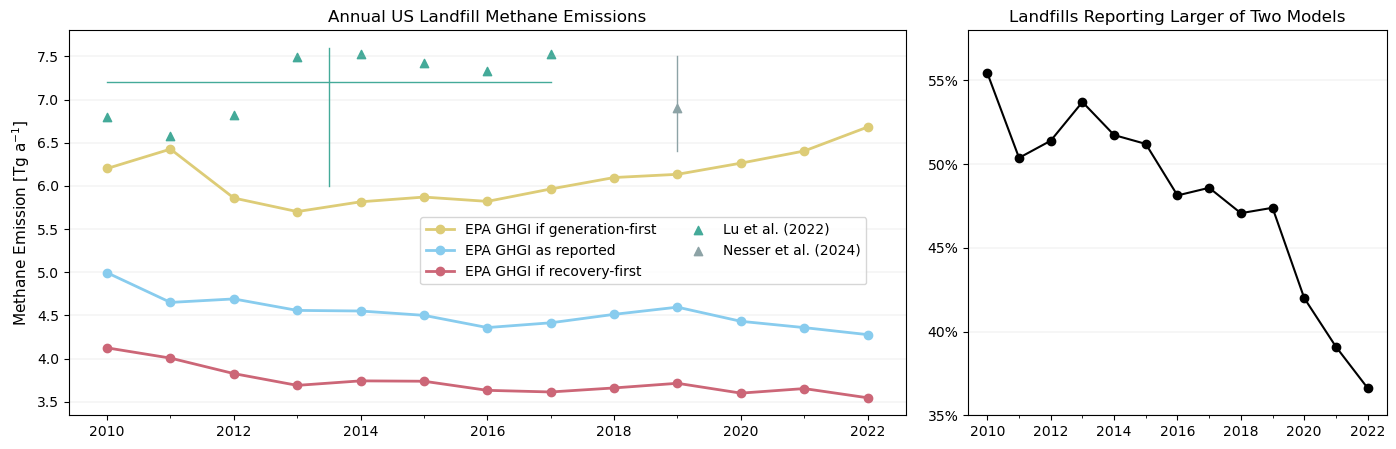

In [5]:
fig,axs = plt.subplots(1,2,figsize=(17,5), gridspec_kw={'width_ratios': [2, 1]})

axs[0].plot(years, totals["Emis_Reported"]/1e3, linewidth=2, color="#88ccee", marker="o", label="EPA GHGI as reported")
axs[0].plot(years, totals["If_All_Recovery_First"]/1e3, linewidth=2, color="#cc6677", marker="o", label="EPA GHGI if recovery-first")
axs[0].plot(years, totals["If_All_Generation_First"]/1e3, linewidth=2, color="#ddcc77", marker="o", label="EPA GHGI if generation-first")
axs[0].grid(axis="y", linewidth=0.15)
axs[0].set_ylabel(r"Methane Emission [Tg a$^{-1}$]", fontsize=11)
axs[0].set_title("Annual US Landfill Methane Emissions")
axs[0].scatter(range(2010,2018), np.array((6.8, 6.58, 6.82, 7.49, 7.53, 7.42, 7.33, 7.53)), marker="^", color="#44aa99", label="Lu et al. (2022)")
axs[0].plot([2010,2017], [7.2,7.2], color="#44aa99", linewidth=1)
axs[0].plot([2013.5,2013.5], [6,7.6], color="#44aa99", linewidth=1)
axs[0].scatter(2019, 6.9, marker="^", color="#8da3a6", label="Nesser et al. (2024)")
axs[0].plot([2019, 2019], [6.4,7.5], color="#8da3a6", linewidth=1, zorder=-1)
handles, labels = axs[0].get_legend_handles_labels()
order = [2,0,1,3,4]
axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=2, loc=(0.42,0.34))

axs[1].plot(years, 100*chose_higher, marker="o", color="k")
axs[1].grid(axis="y", linewidth=0.15)
axs[1].set_title("Landfills Reporting Larger of Two Models")
axs[1].yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:.2g}%"))
axs[1].set_ylim([35,58])

for ax in axs:
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(MultipleLocator(1))

fig.subplots_adjust(wspace=0.1)
fig.savefig("figures/fig3.png", dpi=300, bbox_inches="tight", pad_inches=0.01)

In [6]:
# Linear regression back to 2005
for var in ["Emis_Reported", "If_All_Generation_First", "If_All_Recovery_First"]:
    slope, intercept, _, _, _ = linregress(range(2010,2016), totals[var][0:6])
    totals[var] = np.append(
        (np.arange(2005,2010)*slope + intercept),
        totals[var]
    )

    print(f"{var} --> 2005: {totals[var][0]:.2f}, 2022: {totals[var][-1]:.2f}")

Emis_Reported --> 2005: 5278.36, 2022: 4277.00
If_All_Generation_First --> 2005: 6760.07, 2022: 6681.66
If_All_Recovery_First --> 2005: 4466.54, 2022: 3545.44


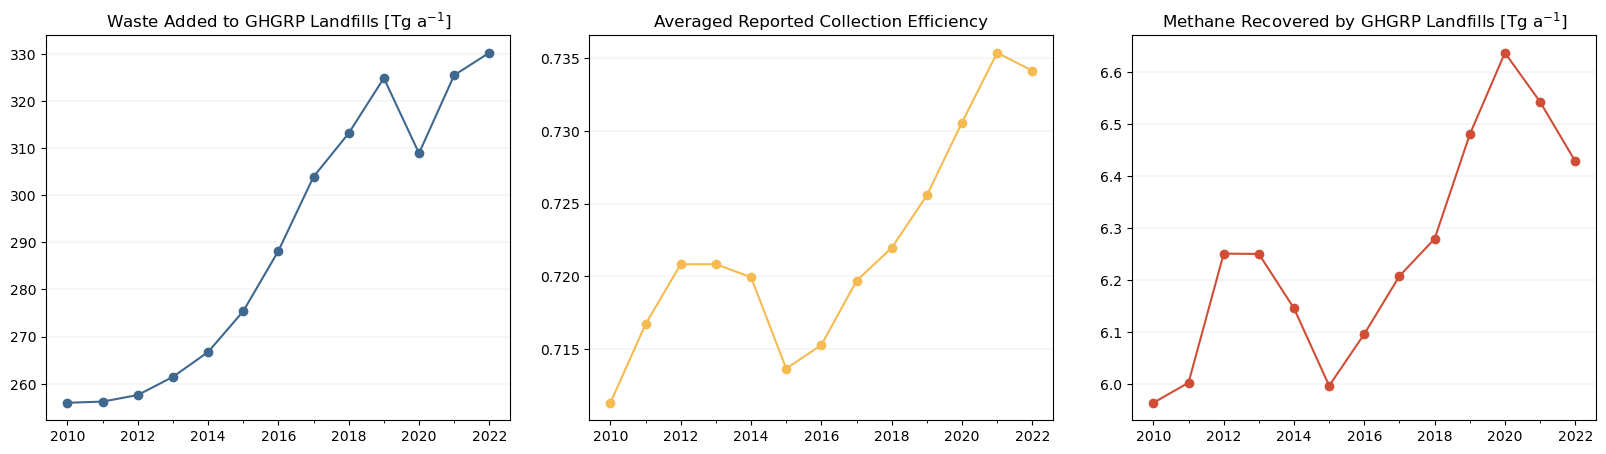

In [7]:
fig,axs = plt.subplots(1,3, figsize=(20,5))

axs[0].plot(years, totals["Waste_Added_This_Yr"]/1e6, marker="o", color="#3f688e")
axs[0].set_title(r"Waste Added to GHGRP Landfills [Tg a$^{-1}$]")
axs[1].plot(years, CE, marker="o", color="#f5bb50")
axs[1].set_title("Averaged Reported Collection Efficiency")
axs[2].plot(years, totals["Recovered"]/1e6, marker="o", color="#d04d36")
axs[2].set_title(r"Methane Recovered by GHGRP Landfills [Tg a$^{-1}$]")

for ax in axs.flatten():
    ax.set_xticks(years)
    ax.grid(axis="y", linewidth=0.15)
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_major_formatter('{x:.0f}')
    ax.xaxis.set_minor_locator(MultipleLocator(1))

fig.subplots_adjust(wspace=0.17)
fig.savefig("figures/figS5.png", dpi=300, bbox_inches="tight", pad_inches=0.01)